In [1]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('annotated-excerpts-with-themes.csv')
print(df.columns)
df = df.loc[df['1 = Relevant / 0 = Irrelevant'] == 1]
df = df.loc[df['1 = Reference'] != 1]

def str2set(x):
    if x == x:
        return set(x)
    return x

def clean(x):
    if type(x) != str:
        return x
    
    x_split = [i for i in x.split(',') if not i.strip().startswith('not ')]
    
    clean_map = {
        'constitutions': 'constitution',
        'emotions': 'emotion',
        'choices': 'choice',
        'arguments': 'argument',
        'campaigns': 'campaign',
        'accountable': 'accountability',
        'debates': 'debate',
        'elections': 'election',
        'deliberaton': 'deliberation',
        'discuourse': 'discourse',
        'dicourse': 'discourse',
        'freedom of speech': 'freedom',
        'harsassment': 'harassment',
        'preventing discrimination': 'discrimination',
        'quality-quantity tradeoff': 'quality vs. quantity tradeoff',
        'not hierarchical (MTL)': 'not hierarchical',
        'critical thinking': 'critical',
        'advancement': 'progress',
        'freedom': 'liberties',
        'civic education': 'education',
        'equal participation': 'equal contribution',
        'not user satisfaction': 'not satisfaction',
        'public reasoning': 'reasoning',
        'reduce need for expertise': 'reduce barriers',
        'political parties': 'political party',
        'protests': 'protest',
    } 
    return [i.strip() if i.strip() not in clean_map else clean_map[i.strip()] for i in x_split]

for col in ['AS Explicit Theme', 'AS Implicit Theme', 'Values',
       'VG Explicit Theme', 'VG Implicit Theme', 'Values.1']:
    df[col] = df[col].apply(clean).apply(str2set)

Index(['Corpus ID', 'Excerpt', '1 = Relevant / 0 = Irrelevant',
       '1 = Reference', 'AS Explicit Theme', 'AS Implicit Theme', 'Values',
       'VG Explicit Theme', 'VG Implicit Theme', 'Values.1', 'Unnamed: 10',
       'democratization cause', 'democratization method(ology)',
       'democratization target', 'democratization goal/result'],
      dtype='object')


In [3]:
def sets2set(x):
    x = x.dropna()
    if len(x) > 0:
        return set.union(*x)
    return set()

as_agg_df = df.groupby('Corpus ID').agg(explicit=('AS Explicit Theme', sets2set), \
                                  implicit=('AS Implicit Theme', sets2set), \
                                  values=('Values', sets2set)
                                 )
vg_agg_df = df.groupby('Corpus ID').agg(explicit=('VG Explicit Theme', sets2set), \
                                  implicit=('VG Implicit Theme', sets2set), \
                                  values=('Values.1', sets2set)
                                 )

In [4]:
agg_df = pd.concat([as_agg_df, vg_agg_df]).groupby('Corpus ID').agg({'explicit': lambda x: set.union(*x), \
                                                            'implicit': lambda x: set.union(*x), \
                                                            'values': lambda x: set.union(*x)})
all_values = sorted(list(set.union(*agg_df['values'])))
print(',\n'.join(repr([v for v in all_values]).split(', ')))

['AI',
'WEIRD',
'acceleration',
'access',
'accountability',
'affordable',
'anti-power',
'anxiety',
'argument',
'available',
'benefit',
'bill writing',
'broader audience',
'campaign',
'caution',
'censorship',
'choice',
'citizenship',
'civility',
'cohesion',
'competence',
'complexity',
'conflict',
'consensus',
'consistency',
'constitution',
'cooperation',
'correctness',
'critical',
'data',
'debate',
'decentralization',
'deliberation',
'dialogue',
'direct democracy',
'disagreement',
'discourse',
'discrimination',
'discussion',
'disinformation',
'distributed',
'diversity',
'ease of use',
'education',
'efficiency',
'election',
'emotion',
'engagement',
'environment',
'equal contribution',
'equal representation',
'equality',
'evolving',
'fairness',
'fast',
'freedom',
'generalizability',
'governance',
'happiness',
'harassment',
'hierarchy of representatives',
'inclusion',
'information',
'informed',
'integrity',
'interaction',
'justice',
'lack of prejudice',
'liberties',
'literacy',
'low-resour

In [5]:
values = set([
    'argument',
    'access',
    'accountability',
    'affordable',
    'anti-power',
    'available',
    'benefit',
    'caution',
    'choice',
    'civility',
    'cohesion',
    'competence',
    'conflict',
    'consensus',
    'consistency',
    'cooperation',
    'correctness',
    'critical',
    'debate',
    'decentralization',
    'deliberation',
    'dialogue',
    'direct democracy',
    'disagreement',
    'discussion',
    'distributed',
    'diversity',
    'ease of use',
    'education',
    'efficiency',
    'engagement',
    'equal contribution',
    'equal representation',
    'equality',
    'evolving',
    'fairness',
    'fast',
    'generalizability',
    'happiness',
    'hierarchy of representatives',
    'inclusion',
    'information',
    'informed',
    'integrity',
    'interaction',
    'justice',
    'lack of prejudice',
    'liberties',
    'literacy',
    'majority',
    'moderation',
    'multilingual',
    'not armed attacks',
    'not authoritarian',
    'not autocratic',
    'not communism',
    'not dictatorship',
    'not fascist',
    'not gatekeeping',
    'not hierarchical',
    'not oligarchic',
    'not populism',
    'not radical Islam',
    'not satisfaction',
    'not socialism',
    'not terrorism',
    'open-source',
    'optimality',
    'participation',
    'power',
    'privacy',
    'proficiency',
    'progress',
    'protection',
    'quality',
    'random selection',
    'rational',
    'reasoning',
    'reduce barriers',
    'reflection',
    'replicability',
    'representation',
    'resource-efficient',
    'responsibility',
    'rights',
    'scalable',
    'social good',
    'sustainability',
    'transparency',
    'trust',
    'value'])

def get_values(x):
    return set([e for e in x if e in values])

In [6]:
def contains(x, theme_set):
    for e in x:
        if e in theme_set:
            return True
    return False

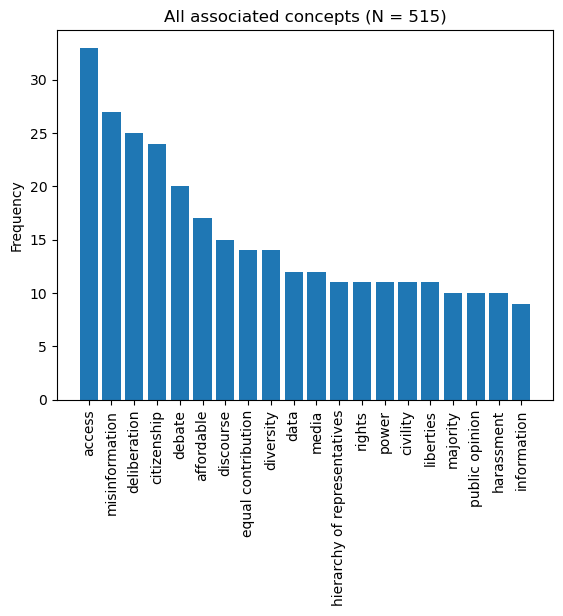

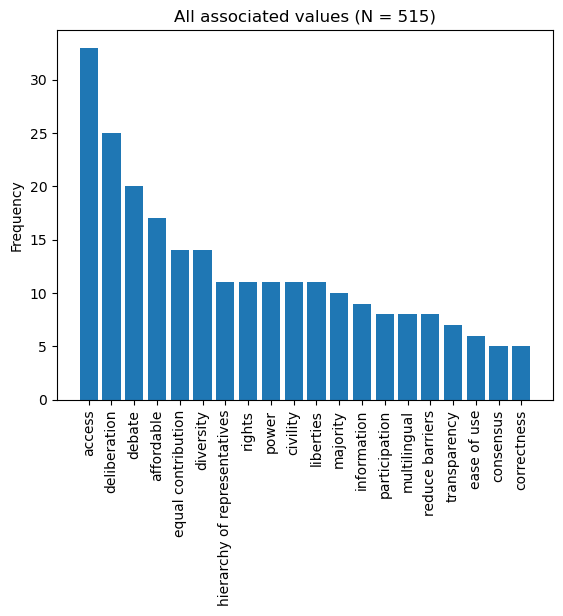

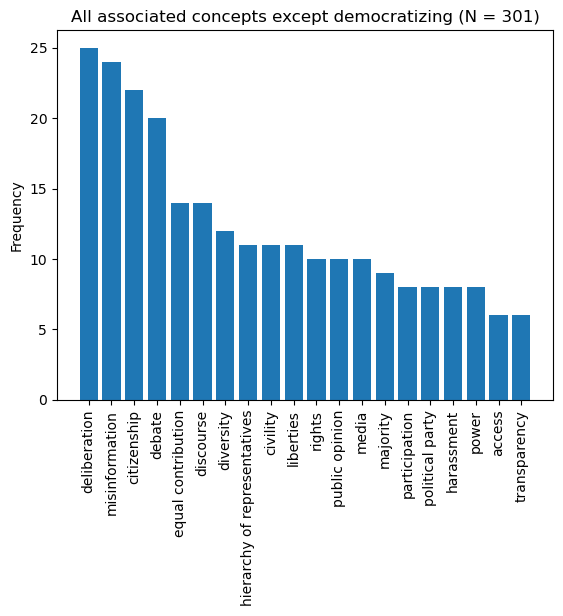

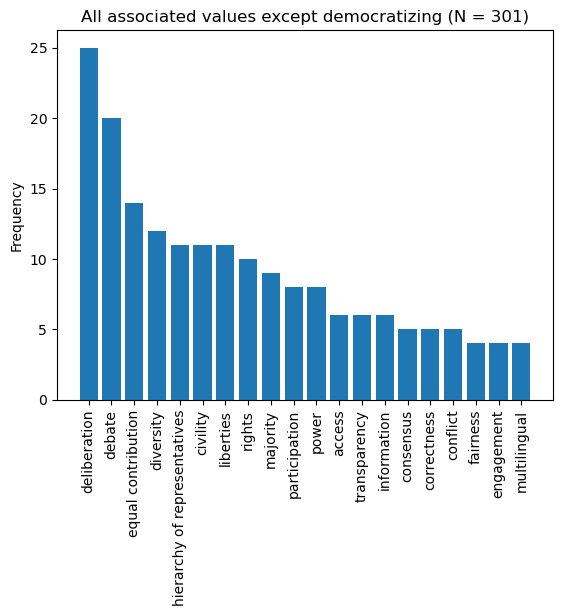

In [7]:
for exclude_explicit, exclude_implicit, exclude_desc in [
    ([], [], ''),
    (set(['democratizing']), set(), 'democratizing')
]:
    filtered_agg_df = agg_df['values'][(~agg_df['explicit'].apply(lambda x: contains(x, exclude_explicit))) \
                                       & (~agg_df['implicit'].apply(lambda x: contains(x, exclude_implicit)))]
    
    freqs = Counter(filtered_agg_df.apply(list).sum())
    
    topk = freqs.most_common(20)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    if exclude_desc != '':
        exclude_desc = 'except ' + exclude_desc + ' '
    plt.title('All associated concepts {}(N = {})'.format(exclude_desc, len(filtered_agg_df)))
    plt.show()
    
    freqs = Counter(filtered_agg_df.apply(get_values).apply(list).sum())
    
    topk = freqs.most_common(20)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    plt.title('All associated values {}(N = {})'.format(exclude_desc, len(filtered_agg_df)))
    plt.show()

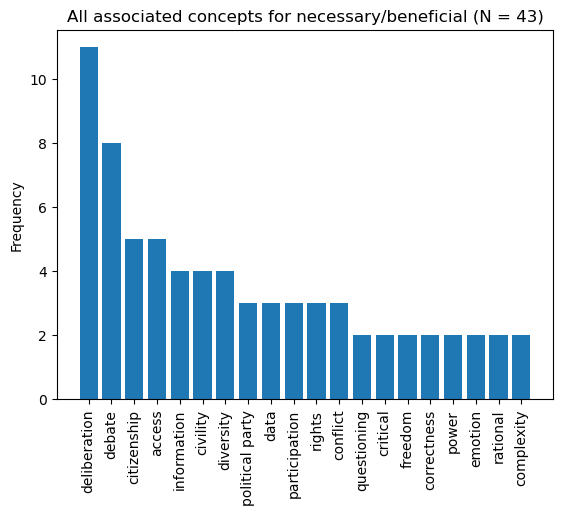

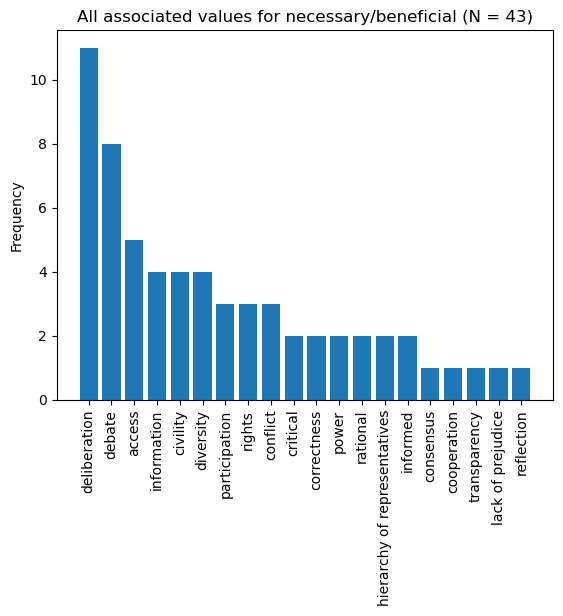

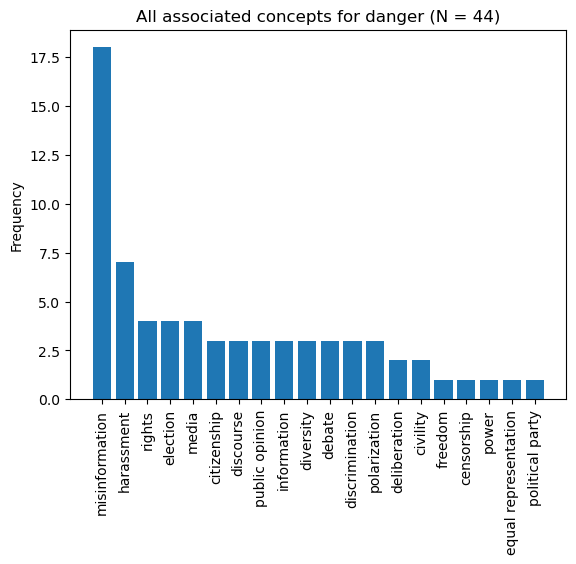

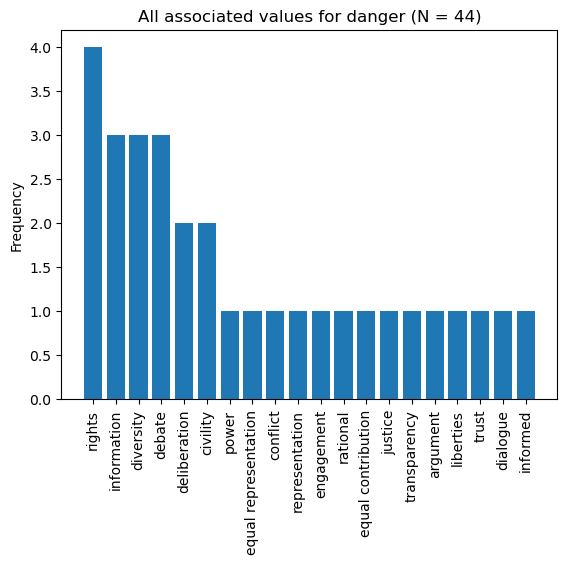

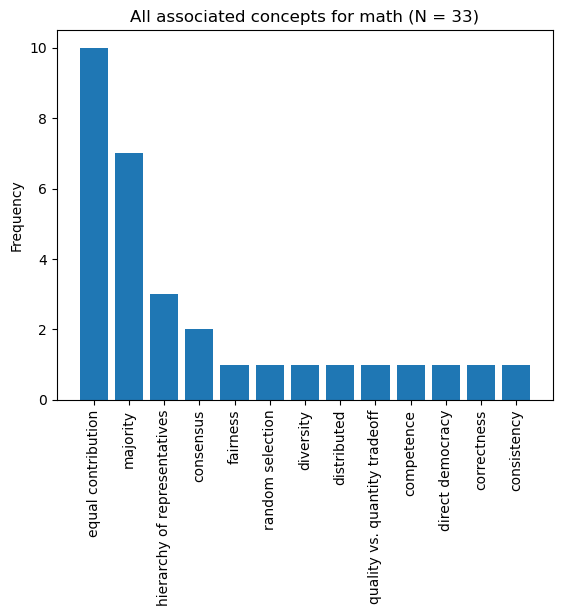

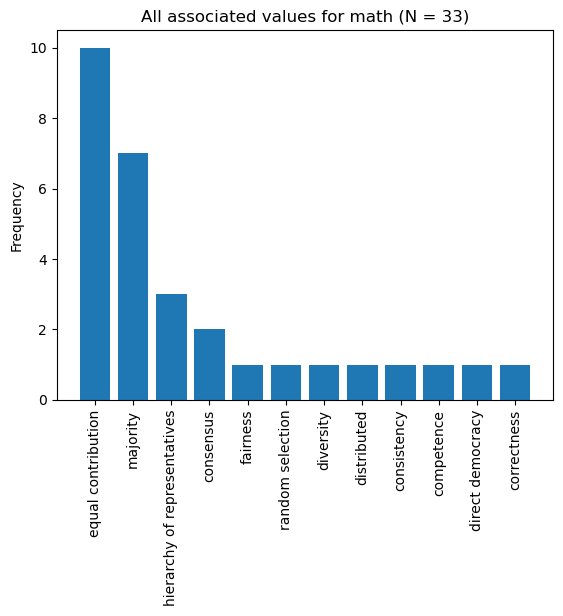

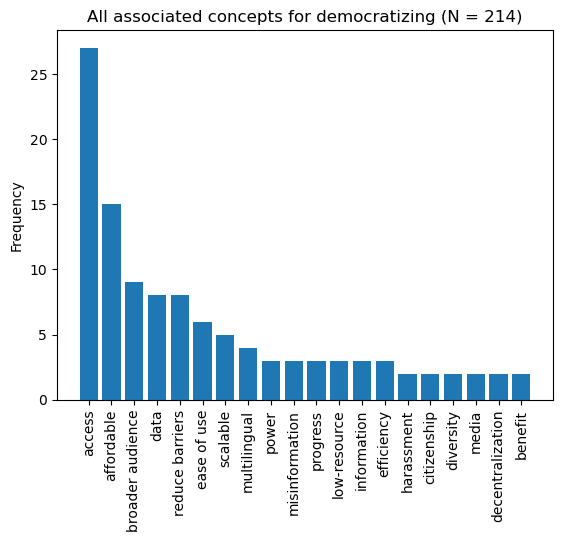

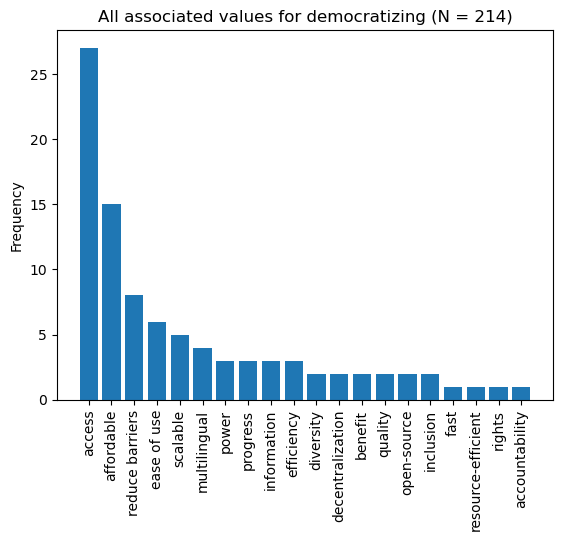

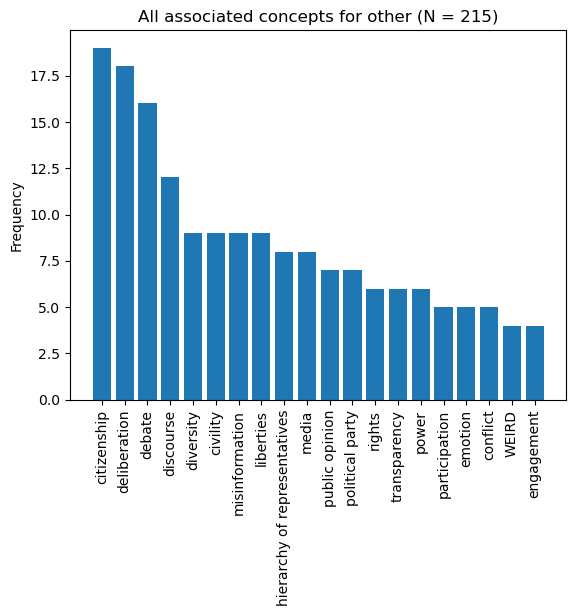

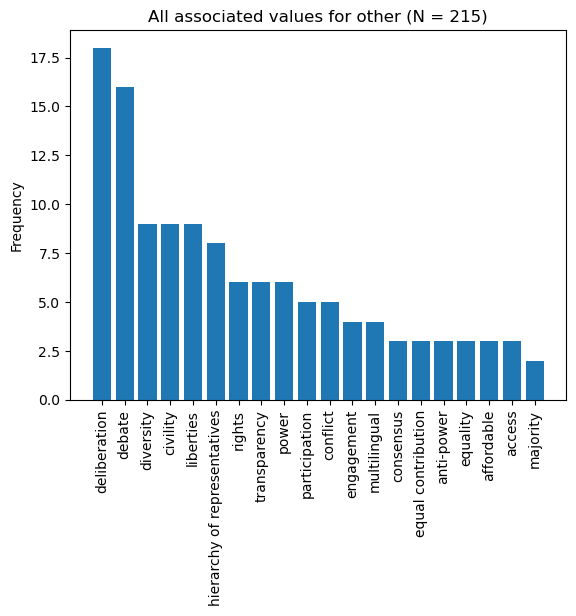

In [8]:
for theme in ['necessary/beneficial', 'danger', 'math', 'democratizing', 'other']:
    include_explicit = set([theme])
    include_implicit = set()
    include_desc = 'for ' + theme + ' '

    filtered_agg_df = agg_df['values'][(agg_df['explicit'].apply(lambda x: contains(x, include_explicit)))]
                                       # | (agg_df['implicit'].apply(lambda x: contains(x, include_implicit)))]
    
    freqs = Counter(filtered_agg_df.apply(list).sum())
    
    topk = freqs.most_common(20)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    plt.title('All associated concepts {}(N = {})'.format(include_desc, len(filtered_agg_df)))
    plt.show()
    
    freqs = Counter(filtered_agg_df.apply(get_values).apply(list).sum())
    
    topk = freqs.most_common(20)
    
    plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    
    plt.title('All associated values {}(N = {})'.format(include_desc, len(filtered_agg_df)))
    plt.show()

## Democratizing

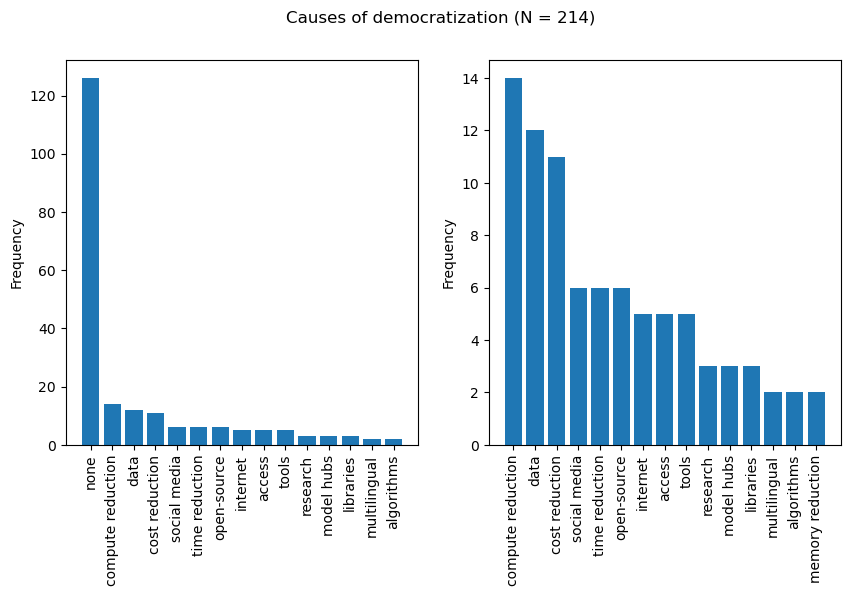

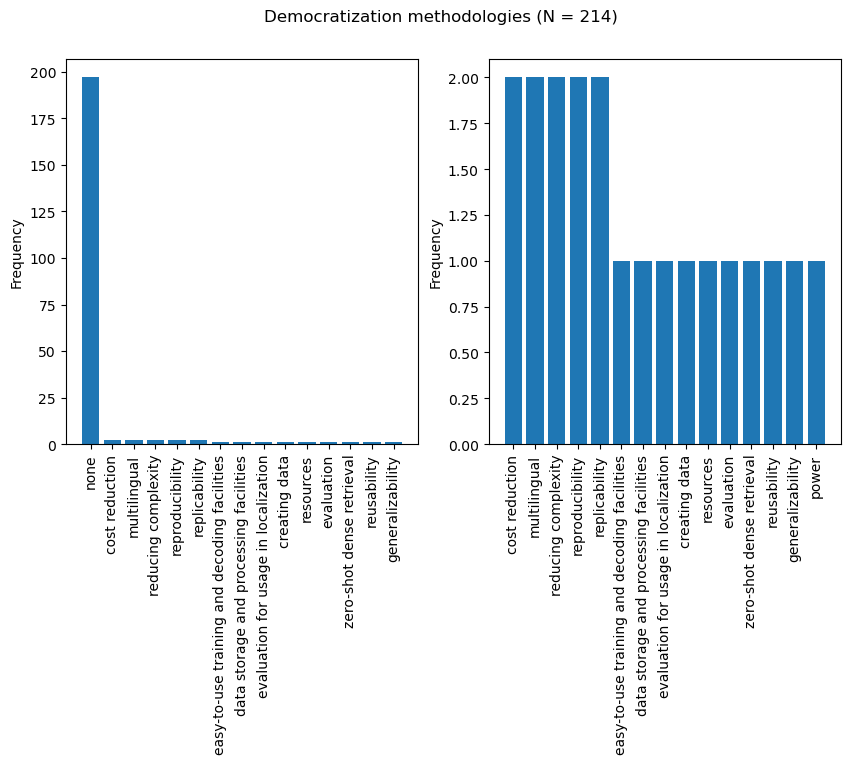

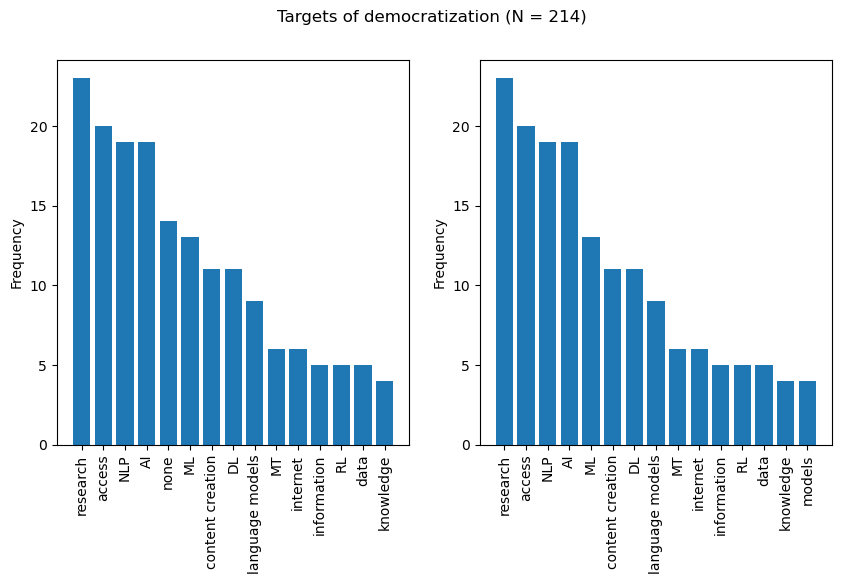

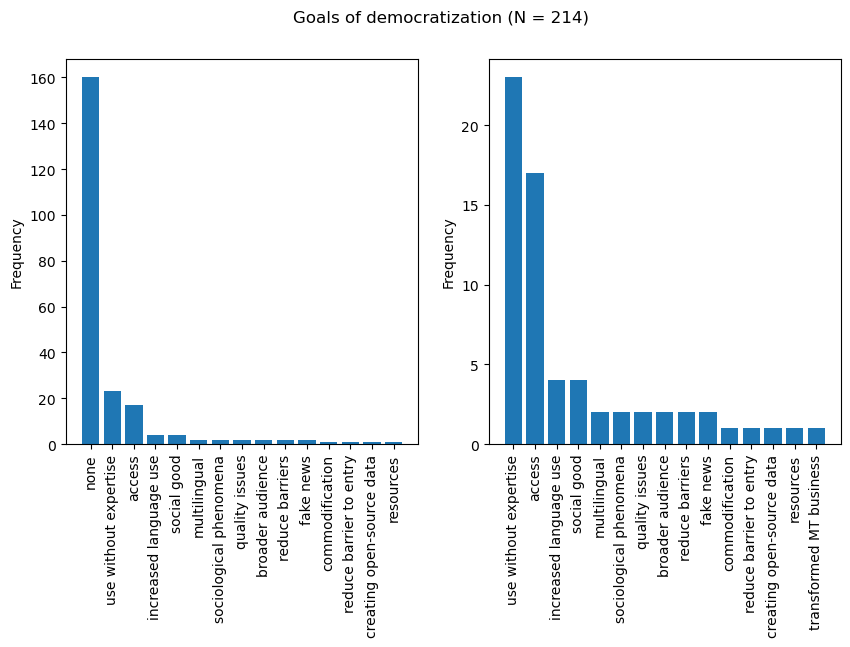

In [19]:
def str2set_withnan(x):
    if x == x:
        return set(x)
    return set(['none'])

for col, title in [('democratization cause', 'Causes of democratization'), \
                        ('democratization method(ology)', 'Democratization methodologies'), \
                        ('democratization target', 'Targets of democratization'), \
                        ('democratization goal/result', 'Goals of democratization')]:
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    for idx, conv_func in enumerate([str2set_withnan, str2set]):
        
        dem_df = pd.read_csv('annotated-excerpts-with-themes.csv')
        dem_df = dem_df.loc[dem_df['1 = Relevant / 0 = Irrelevant'] == 1]
        dem_df = dem_df.loc[dem_df['1 = Reference'] != 1]
        dem_df = dem_df.loc[(dem_df['AS Explicit Theme'] == 'democratizing') | (dem_df['VG Explicit Theme'] == 'democratizing')]

        dem_df[col] = dem_df[col].apply(clean).apply(conv_func)
    
        dem_agg_df = dem_df.groupby('Corpus ID').agg(target=(col, sets2set))
        
        freqs = Counter(dem_agg_df['target'].apply(list).sum())
    
        topk = freqs.most_common(15)

        axs[idx].bar(list(zip(*topk))[0], list(zip(*topk))[1])
        axs[idx].tick_params(axis='x', labelrotation=90)
        axs[idx].set_ylabel('Frequency')

    plt.suptitle('{} (N = {})'.format(title, len(dem_agg_df['target'])))
    plt.show()